# GAN - MNIST
Pytorch GAN implementation with MNIST dataset

### Library import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle

In [2]:
import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

### Data loading

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         # Data normalizing between -1 to 1
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '/home/maparla/DeepLearning/Datasets/PytorchDatasets/MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [4]:
# Call to function to load the MNIST dataset
data = mnist_data()

# Data loader creation
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Data loader number of batches per epoch
num_batches = len(data_loader)

### Constants

In [5]:
LATENT_SPACE = 100

In [6]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 28, 28, 1

### Utility functions

In [7]:
def images_to_vectors(images):
    """
    With this function we can transform images to vectors -> Flatten
    """
    return images.view(images.size(0), IMG_WIDTH*IMG_HEIGHT*IMG_CHANNELS).type(torch.cuda.FloatTensor)

In [8]:
def vectors_to_images(vectors):
    """
    Transform vectors to images
    """
    return vectors.view(vectors.size(0), IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT).type(torch.cuda.FloatTensor)

In [9]:
def noise(samples):
    """
    With this function we create 'samples' (as vectors)
     formed by Gaussian noise with a normal distribution
     with mean 0 and variance 1. Dimension LATENT_SPACE (the same as
     take the generator to sample samples))
    """
    return Variable(torch.randn(samples, LATENT_SPACE)).type(torch.cuda.FloatTensor)

In [10]:
def real_data_target(samples):
    """
    Function to create a vector used to assign the class of the
     different 'samples' during training
     Remember that 1s indicate that the sample is 'real'
    """
    return Variable(torch.ones(samples, 1)).type(torch.cuda.FloatTensor)

In [11]:
def fake_data_target(samples):
    """
    Function to create a vector used to assign the class of the
     different 'samples' during training
     Remember that 0s indicate that the sample is 'fake'
    """
    return Variable(torch.zeros(samples, 1)).type(torch.cuda.FloatTensor)

In [12]:
def make_dir(directory):
    try: os.makedirs(directory)
    except: pass

In [81]:
def save_imgs(test_images, epoch, n_batch, display=False, save=True, custom_name=""):
    fig=plt.figure(figsize = (7,7))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

    for i in range(num_test_samples):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        img = test_images.numpy()[i].reshape(28,28)
        plt.imshow(img, cmap="gray")

    if display: plt.show()
    if save:
        if custom_name!="":
            fig.savefig(custom_name+'.png', bbox_inches='tight')
        else:
            fig.savefig('{}/epoch_{}_batch_{}.png'.format(IMGS_OUT_DIR, epoch, n_batch), bbox_inches='tight')
    plt.close()

### Networks!

#### Discriminator

In [14]:
class DiscriminatorNet(nn.Module):
    """
    Neural network with three hidden layers that will work as a discriminator:
       - Take as input a 'flattened' image (28x28x1 -> 784), and return
         the probability that the image comes from the real dataset.
         (1 -> real) (0 -> synthetic)
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = IMG_WIDTH*IMG_HEIGHT*IMG_CHANNELS # Image as vector
        n_out = 1 # Output neurons. We only need one -> One for say 0 ('fake') or 1 ('real')
        
        # First hidden layer, enter n_features and we have 1024 neurons
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)
        )
        
        # Second hidden layer, enter 1024 neurons of the previous layer and have 512
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)
        )
        
        # Third hidden layer, enter 512 neurons of the previous layer and have 256
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)
        )
        
        # Output layer, 256 neurons from the previous layer enter and we have an 
        # output neuron where the discriminator learns: 1 == Image real data; 0 == Synthetic image
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [15]:
discriminator = DiscriminatorNet().cuda()

#### Generador

In [16]:
class GeneratorNet(nn.Module):
    """
    Neural network of three hidden layers that takes as input a latent variable 
    in a dimensionality vector 100 and returns a output vector of 784 (image of 28x28)
    """
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = LATENT_SPACE # Size of latent space variable
        n_out = IMG_WIDTH*IMG_HEIGHT*IMG_CHANNELS # Output features (image 28x28)
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        # Output layer with 784 neurons that will be used to construct the 'fake' images 
        # and those that try to deceive the discriminator IMPORTANT: The Tanh function is used 
        # to normailze the output between -1 and 1, just as we have normalized the mnist data
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    # We define the forward of the network through the different hidden layers
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [17]:
generator = GeneratorNet().cuda()

#### Optimization

In [18]:
# We will use Adam and a learning rate of 0.0002 for both networks
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [19]:
# The loss function that we will use is Binary Cross Entropy Loss 
loss = nn.BCELoss().cuda()

### Training procedure

We will implement the training process of the two networks, discriminator and generator, in separate functions, where later we will include them in our algorithm and update the weights of both

In [20]:
def train_discriminator(optimizer, real_data, fake_data):
    # Number of samples of real_data
    num_samples = real_data.size(0)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # We must learn that they are real -> 1s
    error_real = loss(prediction_real, real_data_target(num_samples))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # We must learn that they are fake -> 0s
    error_fake = loss(prediction_fake, fake_data_target(num_samples))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [21]:
def train_generator(optimizer, fake_data):
    # Number os samples at fake_data
    num_samples = fake_data.size(0)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Forward our fake_data through the discriminator
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    # IMPORTANT -> We want the generator to learn that
    # your samples are classified as real, so WE CALCULATE THE LOSS WITH 1S! 
    # to make the distribution get closer to generating real data
    error = loss(prediction, real_data_target(num_samples))
    error.backward()
    
    # 3. We update weights and gradients
    optimizer.step()
    
    # Return error
    return error

### Networks Training!

In [22]:
num_test_samples = 16 # Num samples to create at test time
test_noise = noise(num_test_samples) # To generate always the same samples at test time

In [23]:
IMGS_OUT_DIR = "imgs" # Dir to save generated images
make_dir(IMGS_OUT_DIR)

In [24]:
# We will save the error progress
PROGRESS = {"discriminator-error": [], "generator-error": []}

In [25]:
# Total number of epochs to train
num_epochs = 225
total_epochs = 0

In [ ]:
for epoch in range(num_epochs):
    
    # Let's iterate and generate mnist data batches
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # Number of data samples / batch size
        num_samples = real_batch.size(0)
        
        # --------------------------------
        # 1. -- Train the DISCRIMINATOR -- 
        # --------------------------------
        #  -> Transform real images to vectors
        real_data = Variable(images_to_vectors(real_batch))
        # -> Generate fake data (with the generator. It is important use detach to make sure
        # that gradients not goes through the generator
        fake_data = generator(noise(num_samples)).detach()
        # ---> Train the discriminador
        d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator_optimizer, real_data, fake_data)
        
        # ------------------------------
        # 2. --- Train the GENERATOR ---
        # ------------------------------
        # -> Generate fake data (with the generator)
        fake_data = generator(noise(num_samples))
        # ---> Train the generator
        g_error = train_generator(generator_optimizer, fake_data)
        
        
        # Show/Save progress every few batches
        if n_batch % 100 == 0:
            test_images = vectors_to_images(generator(test_noise).detach()).cpu()
            save_imgs(test_images, total_epochs, n_batch)
            
            PROGRESS["discriminator-error"].append(d_error.item())
            PROGRESS["generator-error"].append(g_error.item())
        
    total_epochs+=1
    print("Epoch: {} - Discriminator Error: {:.6f} - Generator Error: {:.6f}".format(epoch, d_error.item(), g_error.item()))

Epoch: 0 - Discriminator Error: 3.477273 - Generator Error: 0.417059
Epoch: 1 - Discriminator Error: 0.803250 - Generator Error: 1.270255
Epoch: 2 - Discriminator Error: 0.235429 - Generator Error: 5.096500
Epoch: 3 - Discriminator Error: 0.464911 - Generator Error: 3.893044
Epoch: 4 - Discriminator Error: 0.444231 - Generator Error: 3.607538
Epoch: 5 - Discriminator Error: 0.573516 - Generator Error: 2.265320
Epoch: 6 - Discriminator Error: 0.609447 - Generator Error: 3.065895
Epoch: 7 - Discriminator Error: 0.555450 - Generator Error: 2.061955
Epoch: 8 - Discriminator Error: 0.564505 - Generator Error: 2.387300
Epoch: 9 - Discriminator Error: 0.510063 - Generator Error: 2.465295
Epoch: 10 - Discriminator Error: 0.736215 - Generator Error: 2.379855
Epoch: 11 - Discriminator Error: 0.516920 - Generator Error: 2.297265
Epoch: 12 - Discriminator Error: 0.750175 - Generator Error: 1.967351
Epoch: 13 - Discriminator Error: 0.610226 - Generator Error: 1.652119
Epoch: 14 - Discriminator Erro

Epoch: 117 - Discriminator Error: 1.233705 - Generator Error: 1.175748
Epoch: 118 - Discriminator Error: 1.357165 - Generator Error: 0.897285
Epoch: 119 - Discriminator Error: 1.385803 - Generator Error: 0.930739
Epoch: 120 - Discriminator Error: 1.211718 - Generator Error: 1.057282
Epoch: 121 - Discriminator Error: 1.266784 - Generator Error: 0.990855
Epoch: 122 - Discriminator Error: 1.246052 - Generator Error: 1.028064
Epoch: 123 - Discriminator Error: 1.219004 - Generator Error: 1.012211
Epoch: 124 - Discriminator Error: 1.211334 - Generator Error: 0.844801
Epoch: 125 - Discriminator Error: 1.241542 - Generator Error: 0.994384
Epoch: 126 - Discriminator Error: 1.401282 - Generator Error: 0.984071
Epoch: 127 - Discriminator Error: 1.288807 - Generator Error: 1.009012
Epoch: 128 - Discriminator Error: 1.461347 - Generator Error: 0.840248
Epoch: 129 - Discriminator Error: 1.245142 - Generator Error: 0.973217
Epoch: 130 - Discriminator Error: 1.227823 - Generator Error: 0.862254
Epoch:

In [ ]:
f = open("progress.pkl","wb")
pickle.dump(PROGRESS,f)
f.close()

In [ ]:
torch.save(generator.state_dict(), "weights/generator_state_dict.pt")
torch.save(discriminator.state_dict(), "weights/discriminator_state_dict.pt")

### Loading models

In [26]:
generator.load_state_dict(torch.load("weights/generator_state_dict.pt"))
discriminator.load_state_dict(torch.load("weights/discriminator_state_dict.pt"))

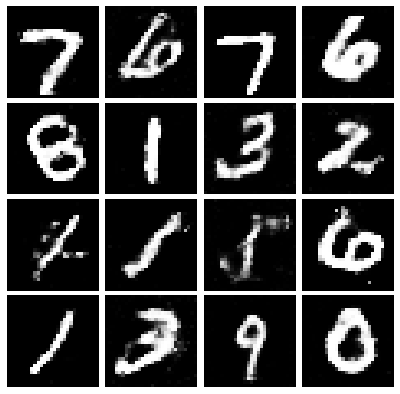

In [40]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=False)

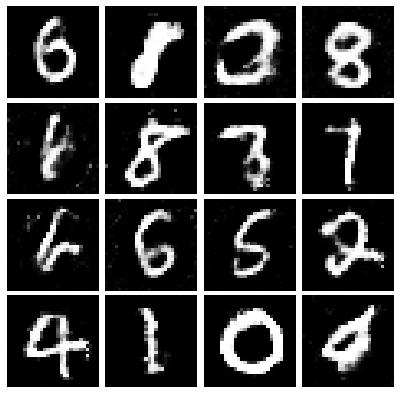

In [41]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=False)

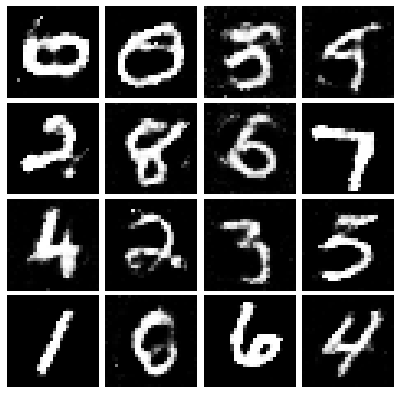

In [77]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=False)

#### Generate GIF

In [137]:
import imageio
import cv2

In [138]:
## Creo una lista donde almacenaremos todas las imagenes leidas
images = []

for epoch in range(0, 225, 2):
    img = imageio.imread("imgs/epoch_{}_batch_0.png".format(epoch))
    img_resized = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
    images.append(img_resized)

In [139]:
for i in range(20):
    # Concateno varias veces la ultima imagen para que quede un poco 'congelada' en el utlimo frame
    images.append(images[-1])

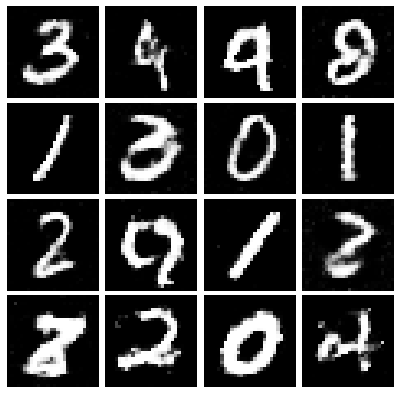

In [86]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=True, custom_name="imgs/sample2")

In [140]:
img = imageio.imread("imgs/sample2.png")
img_resized = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
images.append(img_resized)
for i in range(20):
    # Concateno varias veces la ultima imagen para que quede un poco 'congelada' en el utlimo frame
    images.append(images[-1])

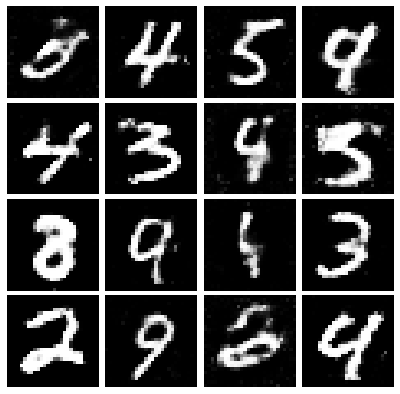

In [88]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=True, custom_name="imgs/sample3")

In [141]:
img = imageio.imread("imgs/sample3.png")
img_resized = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
images.append(img_resized)
for i in range(20):
    # Concateno varias veces la ultima imagen para que quede un poco 'congelada' en el utlimo frame
    images.append(images[-1])

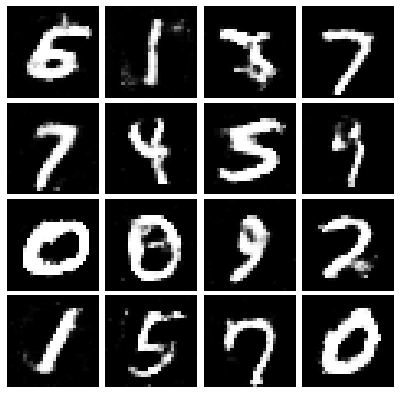

In [90]:
test_noise = noise(num_test_samples) # To generate always the same samples at test time
test_images = vectors_to_images(generator(test_noise).detach()).cpu()
save_imgs(test_images, 0, 0, display=True, save=True, custom_name="imgs/sample4")

In [142]:
img = imageio.imread("imgs/sample4.png")
img_resized = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
images.append(img_resized)
for i in range(20):
    # Concateno varias veces la ultima imagen para que quede un poco 'congelada' en el utlimo frame
    images.append(images[-1])

In [143]:
imageio.mimsave("animation.gif", images)

### Progress Analyze

In [144]:
with open('progress.pkl', 'rb') as f:
    PROGRESS = pickle.load(f)

In [145]:
init, fin = 50, 1000

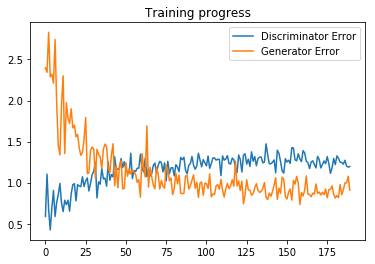

In [148]:
plt.title("Training progress")
plt.plot(np.arange(len(PROGRESS["discriminator-error"][init:fin][1::5])), PROGRESS["discriminator-error"][init:fin][1::5])
plt.plot(np.arange(len(PROGRESS["generator-error"][init:fin][1::5])), PROGRESS["generator-error"][init:fin][1::5])
plt.legend(["Discriminator Error", "Generator Error"])
plt.savefig('progress.eps', format='eps', dpi=1000)